In [ ]:
%pip install devtools --quiet

# **Medical Assistant**

DEFINICAO DE ROTA -- FAZER ISSO NO JAVA / TYPE SCRIPT

Assistente medico genAI tem que decidir e auxiliar para dois scenarios: Emergencial e Diagnostico Diferencial.

Dado o estado de um paciente, ex: dor no peito, calafrio, confusao mental. O assistente tem que decidir se deveria, rotear para a sugestao (state) emergencial ou diagnostico diferencial. 

O Assiste deve saber quando a descrição do usuario é sobre algo que pode estar descrevendo uma doença/fatalidade que pode ocorrer naquele momento, ou uma doença/condicao que precisa de trato imediate ou se o usuario este perguntando,fazendo uma busca sobre um diagnostico diferencial.

Essa applicação tera 3 prompts:
      1. Prompt Rotear se deveramos ir pro state emergencial, pro state diagnostico diferencial, ou usar o tool AskHuman. 
      2. Prompt quando estiver no state emergencial.
      3. Prompt pra quando no state diagnostico differencial.

Explicação dos States
1. emergencial
      - Dado o estado do paciente, o assistente pode, por exemplo, 
      sugerir um pronto atendimento. ex: dor no peito, calafrio, confusao mental. Pode ser infarto.entao sugerir a internacao ou procedimento etc.. 
      - Quando neste state (emergencial) a meta é sugerir algo para ser tomado com um certa urgencia, por isso o nome do state é emergencial.

2. diagnostico diferencial
      - baseado numa descricao (text) do estado do paciente, investigar a causa.
      - Esse sate eh mais pra buscar causas

Explicação do tool AskHuman:
- Se existe duvidas sobre a descrição do paciente, o LLM deve perguntar mais pro usuario para entender sua descrição e decidir pra qual state ir (emergencial ou diagnostico diferencial)


ROUTER_PROMPT:
- se o input do usuario nao eh claro, perguntar pro usuario se é emergencia ou diagnostico differencial.
- Caso de ambiguidade sobre quais decisoes tomar: 
      - algo mais emergencial 
      - busca investigacao 


- Human in the loop para:
      - clarificacao ou confirmacao (confirmacao so pra fins de aprender)
      - confirmacao seria mais pra processos de arvore de decisao

TESTER API do MEMED.
- supondo que .... gerar a receita.
- comeca a testar com o postman


BULARIO
- se puxar 20 remedios, como ele vai mostrar a informacao? uma tabela? 
- batch embedding

In [1]:
import os, sys
from typing import Literal, Optional
from datetime import datetime
from devtools import pprint

from dotenv import load_dotenv
from IPython.display import Image, display
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

# Local imports - prompts
from agent import ROUTER_PROMPT, EMERGENCIAL_PROMPT, DIAGNOSTICO_DIFERENCIAL_PROMPT, \
                  GENERATE_PRESCRIPTION_PROMPT, GENERATE_EXAM_REQUEST_PROMPT, GENERATE_MEDICAL_CERTIFICATE_PROMPT
# Local imports - pydantic classes
from agent import RouterResponse, \
                  LLMPrescription, Doctor, AppointmentTookPlaceIn, Prescription, SkinInfo, \
                  LLMExamRequest, ExamRequest, \
                  LLMMedicalCertificate, MedicalCertificate
# Local imports - Graph state
from agent import State
# Decision options 
from agent import VALID_DECISION_OPTIONS
# Wisecare API
wisecare_path = "/Users/robertagarcia/Desktop/learning/LangGraph/langgraph_personal/NodeInterrupt/medical-assistant/wisecare-prescription"
sys.path.append(wisecare_path)

# Import our prescription generator
from python_wrapper import generate_prescription, generate_exam_request, generate_medical_certificate
# ---- set global variable ---- #
global INTERACTION_COUNT
INTERACTION_COUNT = 0

load_dotenv()  # Load environment variables from the .env file
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGSMITH_TRACING'] = os.getenv('LANGSMITH_TRACING')
os.environ['LANGSMITH_ENDPOINT'] = os.getenv('LANGSMITH_ENDPOINT')
os.environ['LANGSMITH_API_KEY'] = os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT'] = os.getenv('LANGSMITH_PROJECT')

## **Build the Graph - Medical Agent**

In [2]:
m = ChatOpenAI(model="gpt-4o-mini")
model = m.with_structured_output(RouterResponse)

prescription_model = m.with_structured_output(LLMPrescription)

In [ ]:
# LLM router
def llm_router(state: State):
      if state["messages"] and state["messages"][-1].type == "human":
            human_input = state["messages"][-1].content
            print("\nHuman input: ", human_input)

            response = model.invoke(state["messages"])

            print("THIS IS THE ROUTER RESPONSE:")
            pprint(response)
            
            state["decision"] = response.decision
            state["question_to_human"] = response.question_to_human
            state["case_synthesis"] = response.case_synthesis
            print("Added response to state:")
            print("Decision:", state["decision"])
            print("Decision Reason: ", response.decision_reason)
            print("Question to Human:", state["question_to_human"])
            print("Case Synthesis:", state["case_synthesis"])
            
            # Add the next question to human or case_synthesis to the chat history
            if response.question_to_human and response.decision == "ask_human":
                 state["messages"].append(AIMessage(content=response.question_to_human))
            else:
                 state["messages"].append(AIMessage(content=response.case_synthesis))

      else:
            raise ValueError("Expected a human message in state['messages'].")

      return state

# Emergencial
def emergencial(state: State):
      global INTERACTION_COUNT
      print('INSIDE EMERGENCIAL')
      if state["case_synthesis"]:
            input = state["case_synthesis"]
            print(f"Using case_synthesis: {input}")
      else:
            input = next((msg for msg in reversed(state["messages"]) if msg.type == "ai"), state["messages"][1:])
            print(f"Falling back on the last message from the LLM router: {input}")

      response = ChatOpenAI(model="gpt-4o-mini").invoke(EMERGENCIAL_PROMPT.format(input=input))
      state["final_answer"] = response.content
      # Add final answer to the chat history
      state["messages"].append(AIMessage(content=response.content))
      # Reset count
      INTERACTION_COUNT = 0 
      
      return state

# Diagnositico Diferencial
def diagnostico_diferencial(state: State):
      global INTERACTION_COUNT
      print("INSIDE DIAGNOSTICO DIFERENCIAL")
      if state["case_synthesis"]:
            input = state["case_synthesis"]
            print(f"Using case_synthesis: {input}")
      else:
            input = next((msg for msg in reversed(state["messages"]) if msg.type == "ai"), state["messages"][1:])
            print(f"Falling back on the last message from the LLM router: {input}")
      
      response = ChatOpenAI(model="gpt-4o-mini").invoke(DIAGNOSTICO_DIFERENCIAL_PROMPT.format(input=input))
      state["final_answer"] = response.content
      # Add final answer to the chat history
      state["messages"].append(AIMessage(content=response.content))

      # Reset count
      INTERACTION_COUNT = 0 
      
      return state

# Human Node
def ask_human(state: State):
      print(" INSIDE ask_human node")
      question = state["question_to_human"]

      if state["messages"]:
          if not(state["messages"][-1].type == "ai"):
              #last_question = state["messages"][-1].content
              print("Warning: Last message to be asked to human is not of type 'ai'")
      else:
          print("Warning: No messages available in the state. Retaining original question value:", question)

      user_input = interrupt(value=question)     
      
      return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
            }
        ,
        goto="llm_router",
    )

# Gerar Documentos Node
def gerar_documentos(state: State):
    
    print("INSIDE gerar_documentos")
    prescription_prompt =  GENERATE_PRESCRIPTION_PROMPT.format(input = state["case_synthesis"] , conversation_history = "")
    response = prescription_model.invoke(prescription_prompt)
    json_prescription = response.model_dump()
    
    prescription_instance = Prescription(
    consultant = json_prescription.get('consultant'),
    prescriptions = json_prescription.get('prescriptions'),
    doctor = Doctor().model_dump(),
    appointmentTookPlaceIn = AppointmentTookPlaceIn().model_dump(),
)

    prescription_payload = prescription_instance.model_dump()
    print("RECEITA PAYLOAD: \n", prescription_payload)
    
    # Add prescription payload to message history
    state["messages"].append(AIMessage(content="Detalhes da receita médica criada:\n"+str(prescription_payload)))
    
    output_path = os.path.join(wisecare_path, f"output/receita_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
    
    # Send to the Wisecare API
    result = generate_prescription({"prescription" : prescription_payload }, output_path)
    print(f"Receita gerada e salva na pasta: {result}")
    
    return state

# Conditional edge:
def router(state: State):
    global INTERACTION_COUNT
    decision = state.get("decision")
    if not isinstance(decision, str):
        raise ValueError(f"state['decision'] must be a string, but got {decision} of type {type(decision).__name__}")
    
    if decision not in VALID_DECISION_OPTIONS:
        raise ValueError(f"state['decision'] must be one of {VALID_DECISION_OPTIONS}, but got '{decision}'")
    
    if INTERACTION_COUNT >= 3:
         print(f"\n\n ****Warning: interaction number greater than {INTERACTION_COUNT}, routing to emergencial**** \n\n")
         return "emergencial"
    
    elif decision == "ask_human":
        INTERACTION_COUNT += 1 
        print(f"INSIDE ROUTER selected ask_human.\nINTERACTION COUNT: {INTERACTION_COUNT}")
        return "ask_human"
    elif decision == "diagnostico_diferencial":
        print("INSIDE ROUTER selected \"diagnostico_diferencial\"")
        return "diagnostico_diferencial"
    elif decision == "emergencial":
        print("INSIDE ROUTER selected \"emergencial\"")
        return "emergencial"
    elif decision == "gerar_documentos":
         print("INSIDE ROUTER selected \"gerar_documentos\"")
         return "gerar_documentos"

# ----------------------------------
# BUILDING AND COMPILING THE GRAPH
# ----------------------------------
workflow = StateGraph(State)
workflow.add_node("ask_human", ask_human)
workflow.add_node("llm_router", llm_router)  
workflow.add_node("diagnostico_diferencial", diagnostico_diferencial)
workflow.add_node("emergencial", emergencial)
workflow.add_node("gerar_documentos", gerar_documentos)

workflow.add_edge(START, "llm_router")
workflow.add_edge("ask_human", "llm_router")
workflow.add_edge("diagnostico_diferencial", END)
workflow.add_edge("emergencial", END)
# workflow.add_edge("gerar_documentos", END)
workflow.add_conditional_edges("llm_router", router)


memory = MemorySaver()

#agent = workflow.compile(checkpointer=memory)
#display(Image(app.get_graph().draw_mermaid_png()))

def compile_agent():
     return workflow.compile(checkpointer=memory)

app = compile_agent()


In [ ]:
#display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
# testar 4 casos: 
      # ambiguo
      # emergencial
      # diagnostico diferencial
      # gerar documentos

teste_ambiguo = "Tenho dor de cabeça há dois dias." # OKAY 
teste_emergencial = "Dor abdominal intensa acompanhada de hipotensão, palidez e sudorese." # OKAY
teste_diagnostico_diferencial = "Dor lombar persistente por várias semanas, sem irradiação ou sinais de compressão medular." # OKAY
teste_gerar_documento = "Quero receita de tylenol 20mg (1 vez ao dia), para o homem Frederico Antunes, 20 anos." # OKAY


In [ ]:
# teste_gerar_documento
i = 7

config = {"configurable": {"thread_id": f"thread_{i}"}}
for event in app.stream(
    {
        "messages": [
            (
                "system",
                ROUTER_PROMPT
            ),
            (
                "user",
                teste_gerar_documento,  
            )
        ],
        "initial_human_input": teste_gerar_documento
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

## **Testando casos ambiguos**

In [4]:


ambiguous_inputs = [
      #"Tuberculose",
      #"Dor no peito",
      #"Paciente com febre",
      #"Muita dor de ouvido e ansiedade",
      #"Tenho dor de cabeça há dois dias."
      "Melanoma",
      #"Dor de barriga e vomito"
]

emergencial_cases = [
      
#     # "Dor torácica intensa iniciada há 20 minutos, irradiando para o braço esquerdo, com dispneia e sudorese profusa.", # OK
#     #"Início súbito de fraqueza em um lado do corpo, dificuldade para falar e perda de equilíbrio.", # OK
     "Crise asmática com dificuldade respiratória, chiado intenso, cianose e incapacidade de falar", # OK
#     # "Reação alérgica com inchaço da face e lábios, dificuldade para respirar e sensação de desmaio após exposição a um alérgeno conhecido.", # OK
#     #"Dor abdominal intensa acompanhada de hipotensão, palidez e sudorese." # OK

 ]

diagnostico_diferencial_cases = [
    #  "Cefaleia frontal recorrente há meses, sem piora súbita ou sintomas neurológicos associados.", # OK
    #   "Dor lombar persistente por várias semanas, sem irradiação ou sinais de compressão medular.", # OK
    #   "Desconforto torácico leve e intermitente, sem irradiação ou dispneia aguda, com duração de dias.", # OK
    #   "Episódios intermitentes de tontura e vertigem leves, sem perda súbita de força ou alterações visuais.", # OK
    #   "Enxaqueca com aura, acompanhada de dor de cabeça intensa, fotofobia e sintomas visuais, persistindo por horas e melhorando com analgésicos." # OK
]




# poucas palavras, bem vago. 
# Exemplos:
#    - Dor no Peito
#   - Tuberculose
# UI em typescript --> https://github.com/intellidoctor/assistant-ui
    # Depois pluga neste UI

## **GRAPH TO TEST WISECARE API**

In [2]:
m = ChatOpenAI(model="gpt-4o-mini")
model = m.with_structured_output(RouterResponse)

prescription_model = m.with_structured_output(LLMPrescription)
class State(MessagesState):
    decision: Optional[str]
    human_instruction: Optional[str]

sample = State()
sample

{}

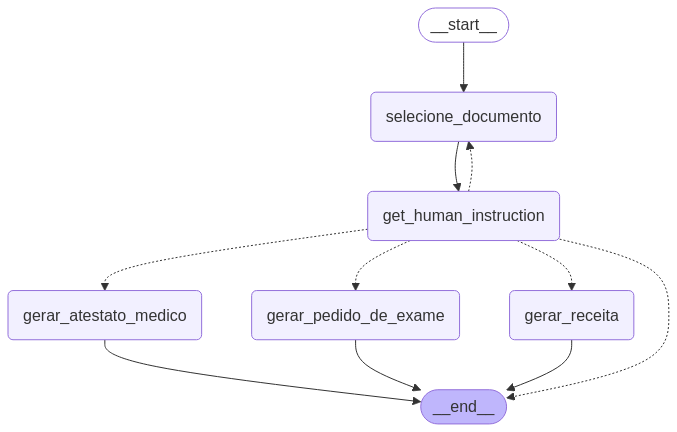

In [3]:
# Nodes
def selecione_documento(state: State):
    user_choices = state["messages"][-1].content #"Qual documento você deseja gerar? (Escolha apenas um número):\n1) Receita médica\n2) Pedido de exame\n3) Atestado médico"
    #state["messages"].append(AIMessage(content=user_choices))

    user_input = interrupt(value=user_choices)
    print("Usuario escolheu: ", user_input)
    if user_input.strip() not in ["1", "2", "3"]:
        print("Entrada inválida. Por favor, insira 1, 2 ou 3.")
    
    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input.strip(),
                }
            ],
            "decision" : user_input.strip()
            }
        ,
        goto="get_human_instruction",
    )

def get_human_instruction(state: State):
    print("INSIDE get_human_instruction, this is state['decision']: ", state["decision"])
    if state["decision"] == "1" :
        interrupt_value = "Para gerar a receita, por favor, forneça as seguintes informações:\n- Nome do paciente\n- Idade\n-Gênero\n- Medicamentos com dosagem e posologia."
    elif state["decision"] == "2" :
        interrupt_value = "Para gerar o pedido de exame, forneça as seguintes informações:\n- Nome do paciente\n- Motivo do pedido\n- Descrição do pedido de exame"
    elif state["decision"] == "3" :
        interrupt_value = "Para gerar um atestado médico, forneça as seguintes informações:\n- Nome do paciente\n-Período de afastamento ou repouso recomendado\n-Descrição do motivo do atestado"
    else: 
        interrupt_value = "Finalizando o graph"
    
    state["messages"].append(AIMessage(content=interrupt_value))
    
    user_input = interrupt(value = interrupt_value)
    print("INSIDE get_human_instructions, user input: ", user_input)
    
    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ],
            "human_instruction" : user_input
            },
            goto="router"

    )

def gerar_receita(state: State):
    print("INSIDE gerar_receita")

    prescription_prompt =  GENERATE_PRESCRIPTION_PROMPT.format(input = state.get("human_instruction") , conversation_history = "")
    response = prescription_model.invoke(prescription_prompt)
    json_prescription = response.model_dump()
    
    prescription_instance = Prescription(
        consultant = json_prescription.get('consultant'),
        prescriptions = json_prescription.get('prescriptions'),
        doctor = Doctor().model_dump(),
        appointmentTookPlaceIn = AppointmentTookPlaceIn().model_dump(),)
    
    # skin info
    skin_info = SkinInfo().model_dump()

    prescription_payload = prescription_instance.model_dump()
    print("RECEITA PAYLOAD: \n", prescription_payload)
    
    # Add prescription payload to message history
    state["messages"].append(AIMessage(content="Detalhes da receita médica criada:\n"+str(prescription_payload)))
    
    output_path = os.path.join(wisecare_path, f"output/receita_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
    
    # Send to the Wisecare API
    result = generate_prescription( prescription_payload, output_path, skin_info = skin_info)
    print(f"Receita gerada e salva na pasta: {result}")
    
    return state

# Node for exam request
def gerar_pedido_de_exame(state: State): 

    print("INSIDE gerar exame")
    exam_request_prompt = GENERATE_EXAM_REQUEST_PROMPT.format(input = state.get("human_instruction") , conversation_history = "")
    model = m.with_structured_output(LLMExamRequest)
    response = model.invoke(exam_request_prompt)
    skin_info = SkinInfo().model_dump()

    exam_request_payload = ExamRequest(
      consultant = response.model_dump().get("consultant"),
      clinicalIndication = response.model_dump().get("clinicalIndication"),
      request = response.model_dump().get("request"),
      doctor =  Doctor(),
      appointmentTookPlaceIn = AppointmentTookPlaceIn(),
      dateOfEmission = datetime.today().strftime("%d/%m/%Y")
    )

    exam_request_payload = exam_request_payload.model_dump()
    print("PAYLOAD FOR EXAM REQUEST: ", exam_request_payload)
    
    # Add exam request payload to message history
    state["messages"].append(AIMessage(content="Detalhes da receita médica criada:\n"+str(exam_request_payload)))
    
    output_path = os.path.join(wisecare_path, f"output/exam_request_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
    result = generate_exam_request(exam_request_payload, output_path, skin_info = skin_info)
    print(f"Pedido de exame gerado e salvo na pasta: {result}")
    return state

# Node for medical certificate
def gerar_atestato_medico(state: State):
    print("INSIDE gerar_atestado_medico")
    medical_certificate_prompt = GENERATE_MEDICAL_CERTIFICATE_PROMPT.format(input = state.get("human_instruction") , conversation_history = "")
    model = m.with_structured_output(LLMMedicalCertificate)
    response = model.invoke(medical_certificate_prompt)
    skin_info = SkinInfo().model_dump()

    medical_certificate_payload = MedicalCertificate(
      consultant = response.consultant,
      period = response.period,
      notes = response.notes,
      doctor =  Doctor(),
      appointmentTookPlaceIn = AppointmentTookPlaceIn(),

    )

    medical_certificate_payload = medical_certificate_payload.model_dump()
    print("PAYLOAD MEDICAL CERTIFICATE: ", medical_certificate_payload)
    
    # Add exam request payload to message history
    state["messages"].append(AIMessage(content="Detalhes do atestado medico:\n"+str(medical_certificate_payload)))
    
    output_path = os.path.join(wisecare_path, f"output/medical_certificate_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
    result = generate_medical_certificate(medical_certificate_payload, output_path, skin_info = skin_info)
    print(f"Atestado medico gerado e salvo na pasta: {result}")

    return state


# Edges
def router(state: State):
    decision = state.get("decision")

    if decision == "1":
        return "gerar_receita"
    elif decision == "2":
        return "gerar_pedido_de_exame"
    elif decision == "3":
        return "gerar_atestato_medico"
    else:
        return END



# ----------------------------------
# BUILDING AND COMPILING THE GRAPH
# ----------------------------------
workflow = StateGraph(State)
workflow.add_node("selecione_documento", selecione_documento)
workflow.add_node("get_human_instruction", get_human_instruction)  
workflow.add_node("gerar_receita", gerar_receita)
workflow.add_node("gerar_pedido_de_exame", gerar_pedido_de_exame)
workflow.add_node("gerar_atestato_medico", gerar_atestato_medico)

workflow.add_edge(START, "selecione_documento")
workflow.add_edge("selecione_documento", "get_human_instruction")
workflow.add_edge("gerar_receita", END)
workflow.add_edge("gerar_pedido_de_exame", END)
workflow.add_edge("gerar_atestato_medico", END)
workflow.add_conditional_edges("get_human_instruction", router)


memory = MemorySaver()

#agent = workflow.compile(checkpointer=memory)
#display(Image(app.get_graph().draw_mermaid_png()))

def compile_agent():
     return workflow.compile(checkpointer=memory)

app = compile_agent()
#display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))
display(Image(app.get_graph().draw_mermaid_png()))



In [4]:
config = {"configurable": {"thread_id": f"i"}}
for event in app.stream(
    {
        "messages": [AIMessage(content="Qual documento você deseja gerar? (Escolha apenas um número):\n1) Receita médica\n2) Pedido de exame\n3) Atestado médico")],
        "decision": "",
        "human_instructions" : ""
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Qual documento você deseja gerar? (Escolha apenas um número):
1) Receita médica
2) Pedido de exame
3) Atestado médico


In [5]:
state = app.get_state(config)
state.next, state.tasks

(('selecione_documento',),
 (PregelTask(id='01d26ce5-f0c5-7e01-93a2-9849c1bdc927', name='selecione_documento', path=('__pregel_pull', 'selecione_documento'), error=None, interrupts=(Interrupt(value='Qual documento você deseja gerar? (Escolha apenas um número):\n1) Receita médica\n2) Pedido de exame\n3) Atestado médico', resumable=True, ns=['selecione_documento:01d26ce5-f0c5-7e01-93a2-9849c1bdc927'], when='during'),), state=None, result=None),))

In [6]:
app.invoke(Command(resume="3"), 
     config=config)

Usuario escolheu:  3
INSIDE get_human_instruction, this is state['decision']:  3


{'messages': [AIMessage(content='Qual documento você deseja gerar? (Escolha apenas um número):\n1) Receita médica\n2) Pedido de exame\n3) Atestado médico', additional_kwargs={}, response_metadata={}, id='1fa5407b-1771-4137-a0bc-8d403f456d10'),
  HumanMessage(content='3', additional_kwargs={}, response_metadata={}, id='898b8104-a84d-4fa3-8727-513f8fbc25c6'),
  AIMessage(content='Para gerar um atestado médico, forneça as seguintes informações:\n- Nome do paciente\n-Período de afastamento ou repouso recomendado\n-Descrição do motivo do atestado', additional_kwargs={}, response_metadata={})],
 'decision': '3'}

In [7]:
state = app.get_state(config)
state.next, state.tasks

(('get_human_instruction',),
 (PregelTask(id='e0e1a2a3-bfa4-ada9-fcaa-eb493e9cc4c0', name='get_human_instruction', path=('__pregel_pull', 'get_human_instruction'), error=None, interrupts=(Interrupt(value='Para gerar um atestado médico, forneça as seguintes informações:\n- Nome do paciente\n-Período de afastamento ou repouso recomendado\n-Descrição do motivo do atestado', resumable=True, ns=['get_human_instruction:e0e1a2a3-bfa4-ada9-fcaa-eb493e9cc4c0'], when='during'),), state=None, result=None),))

In [8]:
app.invoke(
    Command(resume="Pablito necessita atestado medico por conta do seu glaucoma. 10 dias fora sem trabalhar"), 
    config=config
)

INSIDE get_human_instruction, this is state['decision']:  3
INSIDE get_human_instructions, user input:  Pablito necessita atestado medico por conta do seu glaucoma. 10 dias fora sem trabalhar
INSIDE gerar_atestado_medico
PAYLOAD MEDICAL CERTIFICATE:  {'consultant': 'Pablito', 'period': '10 dias', 'notes': 'Necessário atestado médico por conta de glaucoma', 'doctor': {'name': 'Médico Silva', 'crm': '1231231', 'uf': 'PB'}, 'appointmentTookPlaceIn': {'name': 'Nome', 'address': 'Rua das Flores, 137', 'neighbourhood': 'Bairro', 'city': 'Cidade', 'uf': 'PB', 'phone': '11999999999'}}
Medical certificate generated and saved to /Users/robertagarcia/Desktop/learning/LangGraph/langgraph_personal/NodeInterrupt/medical-assistant/wisecare-prescription/output/medical_certificate_20250328_133243.pdf
Atestado medico gerado e salvo na pasta: /Users/robertagarcia/Desktop/learning/LangGraph/langgraph_personal/NodeInterrupt/medical-assistant/wisecare-prescription/output/medical_certificate_20250328_133243.

{'messages': [AIMessage(content='Qual documento você deseja gerar? (Escolha apenas um número):\n1) Receita médica\n2) Pedido de exame\n3) Atestado médico', additional_kwargs={}, response_metadata={}, id='1fa5407b-1771-4137-a0bc-8d403f456d10'),
  HumanMessage(content='3', additional_kwargs={}, response_metadata={}, id='898b8104-a84d-4fa3-8727-513f8fbc25c6'),
  AIMessage(content='Para gerar um atestado médico, forneça as seguintes informações:\n- Nome do paciente\n-Período de afastamento ou repouso recomendado\n-Descrição do motivo do atestado', additional_kwargs={}, response_metadata={}, id='f9ec9605-3849-4d11-9b99-c3726652394a'),
  AIMessage(content='Para gerar um atestado médico, forneça as seguintes informações:\n- Nome do paciente\n-Período de afastamento ou repouso recomendado\n-Descrição do motivo do atestado', additional_kwargs={}, response_metadata={}, id='b68e3900-ba4c-43f9-b0fb-2cf9a1706202'),
  HumanMessage(content='Pablito necessita atestado medico por conta do seu glaucoma.

In [9]:
# EXEMPLO PARA RECEITA MEDICA
config = {"configurable": {"thread_id": f"h"}}
for event in app.stream(
    {
        "messages": [AIMessage(content="Qual documento você deseja gerar? (Escolha apenas um número):\n1) Receita médica\n2) Pedido de exame\n3) Atestado médico")],
        "decision": "",
        "human_instructions" : ""
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Qual documento você deseja gerar? (Escolha apenas um número):
1) Receita médica
2) Pedido de exame
3) Atestado médico


In [10]:
app.invoke(Command(resume="1"), 
     config=config)

Usuario escolheu:  1
INSIDE get_human_instruction, this is state['decision']:  1


{'messages': [AIMessage(content='Qual documento você deseja gerar? (Escolha apenas um número):\n1) Receita médica\n2) Pedido de exame\n3) Atestado médico', additional_kwargs={}, response_metadata={}, id='8391124f-03b4-4539-bce0-2ca9606e78b8'),
  HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='8f4398c1-ddcd-4504-9cb7-ee1a9cf3ea85'),
  AIMessage(content='Para gerar a receita, por favor, forneça as seguintes informações:\n- Nome do paciente\n- Idade\n-Gênero\n- Medicamentos com dosagem e posologia.', additional_kwargs={}, response_metadata={})],
 'decision': '1'}

In [11]:
app.invoke(Command(resume="Receita pro Fernando Albuquerque de 80 anos, genero masculino. Medicamentos: tylenol 10mg 1 vez ao dia, eutyrox 50mg 1 hora antes do cafe da manha, e prozac de 7 ou 8mg antes de dormir."), 
     config=config)

INSIDE get_human_instruction, this is state['decision']:  1
INSIDE get_human_instructions, user input:  Receita pro Fernando Albuquerque de 80 anos, genero masculino. Medicamentos: tylenol 10mg 1 vez ao dia, eutyrox 50mg 1 hora antes do cafe da manha, e prozac de 7 ou 8mg antes de dormir.
INSIDE gerar_receita
RECEITA PAYLOAD: 
 {'codigo': '12314', 'consultant': {'name': 'Fernando Albuquerque', 'age': '80 anos', 'gender': 'masculino'}, 'prescriptions': [{'name': 'Tylenol', 'dosage': '10mg', 'posology': '1 vez ao dia'}, {'name': 'Eutyrox', 'dosage': '50mg', 'posology': '1 hora antes do café da manhã'}, {'name': 'Prozac', 'dosage': '7 ou 8mg', 'posology': 'antes de dormir'}], 'doctor': {'name': 'Médico Silva', 'crm': '1231231', 'uf': 'PB'}, 'appointmentTookPlaceIn': {'name': 'Nome', 'address': 'Rua das Flores, 137', 'neighbourhood': 'Bairro', 'city': 'Cidade', 'uf': 'PB', 'phone': '11999999999'}}
Prescription generated and saved to /Users/robertagarcia/Desktop/learning/LangGraph/langgraph

{'messages': [AIMessage(content='Qual documento você deseja gerar? (Escolha apenas um número):\n1) Receita médica\n2) Pedido de exame\n3) Atestado médico', additional_kwargs={}, response_metadata={}, id='8391124f-03b4-4539-bce0-2ca9606e78b8'),
  HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='8f4398c1-ddcd-4504-9cb7-ee1a9cf3ea85'),
  AIMessage(content='Para gerar a receita, por favor, forneça as seguintes informações:\n- Nome do paciente\n- Idade\n-Gênero\n- Medicamentos com dosagem e posologia.', additional_kwargs={}, response_metadata={}, id='7e7e6497-4115-40a6-ac46-e3b1c601a8d5'),
  HumanMessage(content='Receita pro Fernando Albuquerque de 80 anos, genero masculino. Medicamentos: tylenol 10mg 1 vez ao dia, eutyrox 50mg 1 hora antes do cafe da manha, e prozac de 7 ou 8mg antes de dormir.', additional_kwargs={}, response_metadata={}, id='98781c4a-6650-4af9-b366-c2ad60c6fbb9'),
  AIMessage(content="Detalhes da receita médica criada:\n{'codigo': '12314', 'consu